In [1]:
import torchvision
import torch
import torch.utils.data as utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import tqdm
from torch.autograd import Variable
import argparse
import os
import gc
import matplotlib.pyplot as plt
from copy import deepcopy
from PIL import Image
data_path = '/home/hattie/scratch/datasets/'

from models import ConvBlock, Flatten, LeNet, MnistConvNet, RandomGame, RandomGamePos, WideResNet

In [2]:
class CIFAR10CDataset(Dataset):
    
    """CIFAR10-C dataset."""

    def __init__(self, root, corruption, severity, transform=None, target_transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = np.load(os.path.join(root, corruption, 'severity' + str(severity), 'images.npy'))
        self.targets = torch.tensor(np.load(os.path.join(root, corruption, 'severity' + str(severity), 'labels.npy')))
            
        self.root = root
        self.corruption = corruption
        self.severity = severity
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.targets)
    

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], int(self.targets[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target


In [9]:
trans = ([transforms.ToTensor()])
trans = transforms.Compose(trans)
# fulltrainset = torchvision.datasets.CIFAR10(root=data_path, train=True, download=True, transform=trans)
# train_set, valset = torch.utils.data.random_split(fulltrainset, [45000, 5000])

# trainloader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4)
# validloader = torch.utils.data.DataLoader(valset, batch_size=128, shuffle=False,
#                                           num_workers=4, pin_memory=True)

# test_set = torchvision.datasets.CIFAR10(root=data_path, train=False, download=True, transform=trans)
# testloader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)
# nb_classes = 10


In [4]:
trainset = CIFAR10CDataset(root=data_path + 'CIFAR-10-C/processed_data/', corruption='brightness', severity=1, transform=trans)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)

In [16]:
trainloader.dataset.data.shape#reshape(-1, 3, 32, 32).shape

(10000, 32, 32, 3)

In [91]:
trainloader.dataset.dataset.data.shape

(50000, 32, 32, 3)

In [17]:
testbatch = next(iter(trainloader))

In [22]:
img=testbatch[0][5].numpy()

In [24]:
img = np.dstack([img[0], img[1], img[2]])

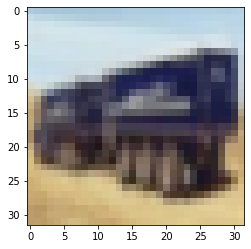

In [25]:
plt.imshow(img)

In [23]:
img.shape

(3, 32, 32)

In [3]:
def test(loader, model, save=False, bn_eval=True):
    
    if bn_eval: # forward prop data twice to update BN running averages
        model.train()
        for _ in range(2):
            for batch_idx, (inputs, targets) in enumerate(loader):
                if use_cuda:
                    inputs, targets = inputs.cuda(), targets.cuda()
                _ = (model(inputs, True))

    model.eval()
    correct, total, total_loss = 0,0,0
    tot_iters = len(loader)
    for batch_idx, (inputs, targets) in enumerate(loader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        with torch.no_grad():
            outputs = (model(inputs, True))

            _, predicted = torch.max(nn.Softmax(dim=1)(outputs).data, 1)
            total += targets.size(0)
            correct += torch.sum(predicted.eq(targets.data)).cpu()
            total_loss += model.loss_fn(outputs, targets).item()

    # Save checkpoint.
    acc = 100.*float(correct)/float(total)
    loss = total_loss/tot_iters
#     if save and acc > best_acc:
#         best_acc = acc
#         print('Saving best model..')
#         state = {
#             'model': model0,
#             'epoch': epoch
#         }
#         with open(args.save_dir + '/best_model.pt', 'wb') as f:
#             torch.save(state, f)
    return loss, acc


In [35]:
epoch = 'init_model'

In [36]:
checkpoint = torch.load('/home/hattie/random_games/exp_cifar_long_lrsh/cifar10_origtest_convnet_trainfirst_iterT99999999_iterR0_iterRsb1_gam0.0_alf1.0_lrT0.1_lrR0.1_momT0.9_momR0_l2T0.0005_l2R0_ep100_seed0_inittypeprev_fromfresh/' + epoch +'.tar')

In [4]:
model = RandomGame(model_func=WideResNet, num_class=10, depth=40, num_classes=10, widen_factor=2, dropRate=0.0)

In [5]:
model.load_state_dict(checkpoint['state_dict'])

NameError: name 'checkpoint' is not defined

In [5]:
use_cuda=True

In [6]:
model.cuda()

RandomGame(
  (feature): WideResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (block1): NetworkBlock(
      (layer): Sequential(
        (0): BasicBlock(
          (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (convShortcut): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): BasicBlock(
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), pa

In [9]:
test(trainloader, model, save=False, bn_eval=False)

(2.5244147626659537, 10.66)

In [32]:
result_dict = {'acc':[], 'loss':[]}

In [33]:
trainset = CIFAR10CDataset(root=data_path + 'CIFAR-10-C/processed_data/', corruption='defocus_blur', severity=1, transform=trans)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)
for epoch in ['3', '6', '9', '12', '15', '18', '21', '24', '27', '30', '33', '36', '39', '42', '45', '48','51','54','57','60','63','66','69','72','75','78','81','84','87','90','93','96','99']:
    checkpoint = torch.load('/home/hattie/random_games/exp_cifar_long_lrsh/cifar10_origtest_convnet_trainfirst_iterT99999999_iterR0_iterRsb1_gam0.0_alf1.0_lrT0.1_lrR0.1_momT0.9_momR0_l2T0.0005_l2R0_ep100_seed0_inittypeprev_fromfresh/' + epoch +'.tar')
    model.load_state_dict(checkpoint['state_dict'])
    loss, acc = test(trainloader, model, save=False, bn_eval=False)
    print(acc)
    result_dict['acc'].append(acc)
    result_dict['loss'].append(loss)

75.03
80.31
78.94
77.85
77.96
84.18
85.6
84.13
85.33
86.15
85.84
84.24
87.97
87.11
84.79
88.5
87.79
88.79
89.31
89.85
89.39
89.6
90.91
91.52
92.15
92.08
92.69
92.83
92.74
93.18
93.46
93.38
92.91


In [34]:
result_dict_game = {'acc':[], 'loss':[]}

In [35]:
trainset = CIFAR10CDataset(root=data_path + 'CIFAR-10-C/processed_data/', corruption='defocus_blur', severity=1, transform=trans)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)
for epoch in ['3', '6', '9', '12', '15', '18', '21', '24', '27', '30', '33', '36', '39', '42', '45', '48','51','54','57','60','63','66','69','72','75','78','81','84','87','90','93','96','99']:
    checkpoint = torch.load('/home/hattie/random_games/exp_cifar_long_lrsh/cifar10_origtest_convnet_randfirst_iterT0_iterR99999999_iterRsb1_gam0.005_alf1.0_lrT0.1_lrR0.1_momT0.9_momR0_l2T0.0005_l2R0_dgm0.99per300_ep100_simt_rpb_seed0_inittypetrue_fromfresh/' + epoch +'.tar')
    model.load_state_dict(checkpoint['state_dict'])
    loss, acc = test(trainloader, model, save=False, bn_eval=False)
    print(acc)
    result_dict_game['acc'].append(acc)
    result_dict_game['loss'].append(loss)

73.3
79.88
81.6
80.63
81.2
81.74
84.06
85.16
86.01
85.13
85.31
84.78
87.54
87.46
86.45
87.49
87.93
89.16
89.75
89.98
89.3
89.92
90.45
91.65
91.77
92.45
92.32
92.42
93.45
93.2
93.4
93.6
93.69


In [71]:
torch.randint(0, 10, (10,)).repeat(3)

tensor([8, 1, 4, 8, 9, 0, 7, 2, 5, 4, 8, 1, 4, 8, 9, 0, 7, 2, 5, 4, 8, 1, 4, 8,
        9, 0, 7, 2, 5, 4])

In [47]:
trans=transforms.Compose(
              [transforms.ToTensor(),
               transforms.Normalize([0.5] * 3, [0.5] * 3)])

In [54]:
results_orig = {}
results_game = {}

In [55]:
for cpt in ['brightness', 'defocus_blur', 'fog', 'gaussian_blur', 'glass_blur', 'jpeg_compression', 'pixelate', 'shot_noise', 'spatter', 'zoom_blur', 'contrast', 'elastic_transform', 'frost', 'gaussian_noise', 'impulse_noise', 'motion_blur', 'saturate', 'snow', 'speckle_noise']:
    results_orig[cpt] = {'acc': [], 'loss': []}
    results_game[cpt] = {'acc': [], 'loss': []}
    
    trainset = CIFAR10CDataset(root=data_path + 'CIFAR-10-C/processed_data/', corruption=cpt, severity=5, transform=trans)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=5)
#     orig_checkpoint = torch.load('/home/hattie/random_games/exp_cifar_long_augmix_jsd_simple/cifar10_convnet_NORMAL_trainfirst_iterT1_iterR1_iterRsb1_gam0_alf1_lrT0.1_lrR0.1_momT0.9_momR0_l2T0.0005_l2R0_ep100_seed0_inittypeprev_AUGMIX_mw3_md-1_sev3_jsd_fromfresh/40.tar')
    orig_checkpoint = torch.load('/home/hattie/random_games/clean_exp_cifar_fast/cifar10_convnet_NORMAL_trainfirst_iterT1_iterR1_iterRsb1_gam0_alf1_lrT0.1_lrR0.1_momT0.9_momR0_l2T0.0005_l2R0_ep100_seed0_inittypeprev_AUGMIX_mw3_md-1_sev3_fromfresh/final_model.tar')
    game_checkpoint = torch.load('/home/hattie/random_games/clean_exp_cifar_fast/cifar10_convnet_trainfirst_iterT1_iterR1_iterRsb1_gam0.003_alf1.0_lrT0.1_lrR0.1_momT0.9_momR0_l2T0.0005_l2R0.0_dgm0.95per300_ep100_simt_seed0_inittypereinit_AUGMIX_mw3_md-1_sev3_fromfresh/final_model.tar')

    model.load_state_dict(orig_checkpoint['state_dict'])
    loss, acc = test(trainloader, model, save=False, bn_eval=False)
    print(acc)
    results_orig[cpt]['acc'].append(acc)
    results_orig[cpt]['loss'].append(loss)
    
    model.load_state_dict(game_checkpoint['state_dict'])
    loss, acc = test(trainloader, model, save=False, bn_eval=False)
    print(acc)
    results_game[cpt]['acc'].append(acc)
    results_game[cpt]['loss'].append(loss)

91.61
91.52
87.33
86.65
82.82
82.53
83.49
82.53
61.57
58.07
77.57
76.12
55.1
57.67
69.14
64.95
87.97
87.22
85.7
84.56
78.17
79.69
74.6
71.79
80.67
77.75
62.52
56.67
61.67
53.03
83.89
83.09
90.06
90.6
82.45
79.28
73.1
68.53


In [50]:
agg_orig = []
for a in results_orig.values():
    agg_orig.append(a['acc'][0])

In [51]:
np.mean(agg_orig)

80.63052631578948

In [52]:
agg_game = []
for a in results_game.values():
    agg_game.append(a['acc'][0])

In [53]:
np.mean(agg_game)

80.06421052631579

In [55]:
results_orig

{'brightness': {'acc': [90.78], 'loss': [0.34607925322614136]},
 'defocus_blur': {'acc': [86.2], 'loss': [0.5251836548500424]},
 'fog': {'acc': [78.28], 'loss': [0.8649170493023305]},
 'gaussian_blur': {'acc': [81.87], 'loss': [0.6962963978323755]},
 'glass_blur': {'acc': [55.47], 'loss': [1.907024332239658]},
 'jpeg_compression': {'acc': [75.62], 'loss': [0.9691366191151776]},
 'pixelate': {'acc': [64.04], 'loss': [1.5472308502921575]},
 'shot_noise': {'acc': [62.3], 'loss': [1.4410294973397557]},
 'spatter': {'acc': [86.23], 'loss': [0.5514675822061829]},
 'zoom_blur': {'acc': [83.85], 'loss': [0.6549653131750566]},
 'contrast': {'acc': [76.11], 'loss': [0.8479700209219244]},
 'elastic_transform': {'acc': [71.34], 'loss': [1.190527531165111]},
 'frost': {'acc': [74.1], 'loss': [1.063883372499973]},
 'gaussian_noise': {'acc': [55.6], 'loss': [1.730150290682346]},
 'impulse_noise': {'acc': [54.62], 'loss': [1.5949873501741434]},
 'motion_blur': {'acc': [81.47], 'loss': [0.7060564277292

In [56]:
results_game

{'brightness': {'acc': [92.22], 'loss': [0.2665015467548672]},
 'defocus_blur': {'acc': [88.92], 'loss': [0.4016039978854264]},
 'fog': {'acc': [83.8], 'loss': [0.6084768085540095]},
 'gaussian_blur': {'acc': [86.56], 'loss': [0.47652678851839864]},
 'glass_blur': {'acc': [62.35], 'loss': [1.3849287123619756]},
 'jpeg_compression': {'acc': [75.39], 'loss': [0.9439749121665955]},
 'pixelate': {'acc': [56.69], 'loss': [2.0575858384748047]},
 'shot_noise': {'acc': [71.39], 'loss': [0.9385999931564813]},
 'spatter': {'acc': [86.74], 'loss': [0.48180748805215085]},
 'zoom_blur': {'acc': [87.73], 'loss': [0.43371568280684797]},
 'contrast': {'acc': [82.6], 'loss': [0.5706020714361456]},
 'elastic_transform': {'acc': [77.08], 'loss': [0.8425242331209062]},
 'frost': {'acc': [81.04], 'loss': [0.6867305349700058]},
 'gaussian_noise': {'acc': [65.96], 'loss': [1.134965120991574]},
 'impulse_noise': {'acc': [66.59], 'loss': [1.0374340460270266]},
 'motion_blur': {'acc': [86.11], 'loss': [0.492056

In [12]:
results_game

{'brightness': {'acc': [91.48], 'loss': [0.26471847795610187]},
 'defocus_blur': {'acc': [89.18], 'loss': [0.36125521210930017]},
 'fog': {'acc': [80.08], 'loss': [0.7543166792845424]},
 'gaussian_blur': {'acc': [87.5], 'loss': [0.4211588479767117]},
 'glass_blur': {'acc': [68.55], 'loss': [1.114969718682615]},
 'jpeg_compression': {'acc': [78.85], 'loss': [0.7164509104022497]},
 'pixelate': {'acc': [61.47], 'loss': [1.7852182433575015]},
 'shot_noise': {'acc': [77.03], 'loss': [0.8337837902805473]},
 'spatter': {'acc': [88.48], 'loss': [0.36740101213696635]},
 'zoom_blur': {'acc': [88.37], 'loss': [0.40307141368902183]},
 'contrast': {'acc': [83.57], 'loss': [0.5576626801792579]},
 'elastic_transform': {'acc': [77.42], 'loss': [0.7944916532009463]},
 'frost': {'acc': [81.95], 'loss': [0.6243118745616719]},
 'gaussian_noise': {'acc': [72.29], 'loss': [1.016733348746843]},
 'impulse_noise': {'acc': [71.28], 'loss': [1.0443973805330977]},
 'motion_blur': {'acc': [86.28], 'loss': [0.46073

In [66]:
trans = ([transforms.ToTensor()])
trans = transforms.Compose(trans)

In [67]:
results_orig = {}
results_game = {}

In [57]:
for cpt in ['brightness', 'defocus_blur', 'fog', 'gaussian_blur', 'glass_blur', 'jpeg_compression', 'pixelate', 'shot_noise', 'spatter', 'zoom_blur', 'contrast', 'elastic_transform', 'frost', 'gaussian_noise', 'impulse_noise', 'motion_blur', 'saturate', 'snow', 'speckle_noise']:
    results_orig[cpt] = {'acc': [], 'loss': []}
    results_game[cpt] = {'acc': [], 'loss': []}
    
    trainset = CIFAR10CDataset(root=data_path + 'CIFAR-10-C/processed_data/', corruption=cpt, severity=1, transform=trans)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)
    orig_checkpoint = torch.load('/home/hattie/random_games/exp_cifar_long_lrsh/cifar10_origtest_convnet_trainfirst_iterT99999999_iterR0_iterRsb1_gam0.0_alf1.0_lrT0.1_lrR0.1_momT0.9_momR0_l2T0.0005_l2R0_ep100_seed0_inittypeprev_fromfresh/60.tar')
    game_checkpoint = torch.load('/home/hattie/random_games/exp_cifar_long_lrsh/cifar10_origtest_convnet_randfirst_iterT0_iterR99999999_iterRsb1_gam0.005_alf1.0_lrT0.1_lrR0.1_momT0.9_momR0_l2T0.0005_l2R0_dgm0.99per300_ep100_simt_rpb_seed0_inittypereinit_fromfresh/60.tar')

    model.load_state_dict(orig_checkpoint['state_dict'])
    loss, acc = test(trainloader, model, save=False, bn_eval=False)
    print(acc)
    results_orig[cpt]['acc'].append(acc)
    results_orig[cpt]['loss'].append(loss)
    
    model.load_state_dict(game_checkpoint['state_dict'])
    loss, acc = test(trainloader, model, save=False, bn_eval=False)
    print(acc)
    results_game[cpt]['acc'].append(acc)
    results_game[cpt]['loss'].append(loss)

57.2
53.19
51.65
45.18
50.63
47.1
51.63
45.1
23.05
23.88
35.45
37.56
45.99
42.28
25.19
35.78
45.1
39.95


KeyboardInterrupt: 

In [17]:
results_orig

{'brightness': {'acc': [86.29], 'loss': [0.4313202079715608]},
 'defocus_blur': {'acc': [40.82], 'loss': [2.4987941059885146]},
 'fog': {'acc': [50.44], 'loss': [1.8931927975220015]},
 'gaussian_blur': {'acc': [24.84], 'loss': [3.7307366691058195]},
 'glass_blur': {'acc': [34.86], 'loss': [2.8526173301889926]},
 'jpeg_compression': {'acc': [61.28], 'loss': [1.2879614105707482]},
 'pixelate': {'acc': [43.69], 'loss': [2.448532951029041]},
 'shot_noise': {'acc': [22.88], 'loss': [4.104322723195523]},
 'spatter': {'acc': [66.97], 'loss': [1.235687377332132]},
 'zoom_blur': {'acc': [49.77], 'loss': [2.0439781388149987]},
 'contrast': {'acc': [15.04], 'loss': [4.684663030165661]},
 'elastic_transform': {'acc': [60.55], 'loss': [1.3691791778878322]},
 'frost': {'acc': [49.23], 'loss': [2.2658650754373286]},
 'gaussian_noise': {'acc': [19.72], 'loss': [4.578324936613252]},
 'impulse_noise': {'acc': [22.24], 'loss': [3.585437276695348]},
 'motion_blur': {'acc': [52.73], 'loss': [1.729295336747

In [ ]:
results_game

In [13]:
results_orig

{'brightness': {'acc': [79.52], 'loss': [0.6323486830614791]},
 'defocus_blur': {'acc': [44.13], 'loss': [1.9776507812210276]},
 'fog': {'acc': [36.47], 'loss': [2.3373406054098393]},
 'gaussian_blur': {'acc': [33.64], 'loss': [2.439745436740827]},
 'glass_blur': {'acc': [27.32], 'loss': [2.784815537778637]},
 'jpeg_compression': {'acc': [56.64], 'loss': [1.49065524264227]},
 'pixelate': {'acc': [49.79], 'loss': [1.6461901528925835]},
 'shot_noise': {'acc': [34.54], 'loss': [2.43709249285203]},
 'spatter': {'acc': [65.49], 'loss': [1.1372178604331198]},
 'zoom_blur': {'acc': [46.14], 'loss': [1.9215106737764576]},
 'contrast': {'acc': [17.26], 'loss': [3.2766419996189167]},
 'elastic_transform': {'acc': [42.34], 'loss': [2.1067700386047363]},
 'frost': {'acc': [36.64], 'loss': [2.278720914563046]},
 'gaussian_noise': {'acc': [31.43], 'loss': [2.6766964363146433]},
 'impulse_noise': {'acc': [29.13], 'loss': [2.442348124105719]},
 'motion_blur': {'acc': [42.93], 'loss': [1.89475191695780

In [14]:
results_game

{'brightness': {'acc': [79.26], 'loss': [0.6033549074885212]},
 'defocus_blur': {'acc': [57.59], 'loss': [1.232693055008031]},
 'fog': {'acc': [45.88], 'loss': [1.725538744202143]},
 'gaussian_blur': {'acc': [48.47], 'loss': [1.527073774156691]},
 'glass_blur': {'acc': [31.98], 'loss': [2.924145369590083]},
 'jpeg_compression': {'acc': [58.02], 'loss': [1.296011676516714]},
 'pixelate': {'acc': [41.49], 'loss': [2.330309428746187]},
 'shot_noise': {'acc': [29.45], 'loss': [2.999531021601037]},
 'spatter': {'acc': [65.75], 'loss': [1.0944994122167178]},
 'zoom_blur': {'acc': [54.06], 'loss': [1.3984214716319796]},
 'contrast': {'acc': [22.11], 'loss': [2.560234136219266]},
 'elastic_transform': {'acc': [47.12], 'loss': [1.8310311987430234]},
 'frost': {'acc': [41.09], 'loss': [2.428653087797044]},
 'gaussian_noise': {'acc': [24.89], 'loss': [3.3553701956060866]},
 'impulse_noise': {'acc': [28.58], 'loss': [2.7128475829015803]},
 'motion_blur': {'acc': [49.49], 'loss': [1.602017289475549

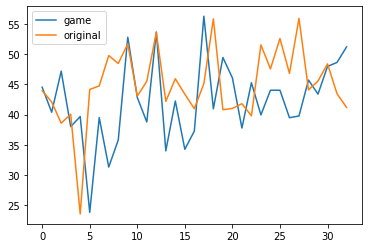

In [31]:
plt.plot(result_dict_game['acc'], label = 'game')
plt.plot(result_dict['acc'], label = 'original')
plt.legend()

In [43]:
for sev in [1,2,3,4,5]:
    result_dict['sev'+str(sev)] = {'acc':[], 'loss':[]}
    trainset = CIFAR10CDataset(root=data_path + 'CIFAR-10-C/processed_data/', corruption='brightness', severity=sev, transform=trans)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)
    for epoch in ['init_model','3', '6', '9', '12', '15', '18', '21', '24', '27', '30', '33', '36', '39', '42', '45', '48','51','54','57','60','63','66','69','72','75','78','81','84','87','90','93','96','99']:
        checkpoint = torch.load('/home/hattie/random_games/exp_cifar_long_lrsh/cifar10_origtest_convnet_trainfirst_iterT99999999_iterR0_iterRsb1_gam0.0_alf1.0_lrT0.1_lrR0.1_momT0.9_momR0_l2T0.0005_l2R0_ep100_seed0_inittypeprev_fromfresh/' + epoch +'.tar')
        model.load_state_dict(checkpoint['state_dict'])
        loss, acc = test(trainloader, model, save=False, bn_eval=False)
        print(acc)
        result_dict['sev'+str(sev)]['acc'].append(acc)
        result_dict['sev'+str(sev)]['loss'].append(loss)
#     print(model.test_loop(base_loader))
#     print(model.test_loop(val_loader))

10.0
72.66
80.63
80.06
78.94
80.67
84.06
85.88
84.29
85.49
86.72
86.45
85.58
87.5
87.39
85.32
88.23
87.85
89.34
89.76
90.22
89.65
90.1
91.38
91.63
92.12
92.29
92.77
92.91
93.41
93.43
93.49
93.53
93.33
10.0
71.73
79.92
79.96
78.52
80.73
83.35
85.61
83.8
85.04
86.16
85.78
85.36
87.11
86.35
85.08
87.69
87.25
88.95
89.61
90.13
89.28
89.85
91.08
91.22
91.53
92.02
92.51
92.38
93.12
93.06
93.37
93.16
92.95
10.0
70.32
78.64
78.9
77.47
80.19
82.06
84.92
83.38
84.35
85.29
84.84
84.83
86.53
85.39
84.75
86.87
86.24
88.39
89.05
89.39
88.81
89.24
90.36
90.56
90.81
91.32
91.84
91.8
92.74
92.33
92.83
92.68
92.47
10.0
68.99
77.19
77.59
76.44
79.46
80.53
83.98
82.43
83.48
84.22
83.36
83.59
85.12
83.89
83.89
85.93
84.87
87.57
88.05
88.84
88.04
88.43
89.61
89.33
89.72
90.45
90.95
91.0
91.86
91.62
92.16
92.02
91.81
10.0
66.15
73.25
74.51
72.85
76.12
77.08
81.37
79.42
80.43
81.05
79.75
80.19
82.61
79.83
80.71
83.56
81.19
85.35
85.63
86.29
85.75
86.08
86.75
86.09
87.22
87.25
88.01
88.33
89.88
89.56
89.74
89.

In [ ]:
result_dict_game = {}

In [ ]:
for sev in [1,2,3,4,5]:
    result_dict_game['sev'+str(sev)] = {'acc':[], 'loss':[]}
    trainset = CIFAR10CDataset(root=data_path + 'CIFAR-10-C/processed_data/', corruption='brightness', severity=sev, transform=trans)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)
    for epoch in ['init_model','3', '6', '9', '12', '15', '18', '21', '24', '27', '30', '33', '36', '39', '42', '45', '48','51','54','57','60','63','66','69','72','75','78','81','84','87','90','93','96','99']:
        checkpoint = torch.load('/home/hattie/random_games/exp_cifar_long_lrsh/cifar10_origtest_convnet_randfirst_iterT0_iterR99999999_iterRsb1_gam0.005_alf1.0_lrT0.1_lrR0.1_momT0.9_momR0_l2T0.0005_l2R0_dgm0.99per300_ep100_simt_rpb_seed0_inittypetrue_fromfresh/' + epoch +'.tar')
        model.load_state_dict(checkpoint['state_dict'])
        loss, acc = test(trainloader, model, save=False, bn_eval=False)
        print(acc)
        result_dict_game['sev'+str(sev)]['acc'].append(acc)
        result_dict_game['sev'+str(sev)]['loss'].append(loss)
#     print(model.test_loop(base_loader))
#     print(model.test_loop(val_loader))

In [ ]:
    with h5py.File(os.path.join(workdir, 'perf_metrics.h5'), 'w') as f:
        f.attrs['print_every'] = args.print_every
        f.attrs['num_epochs'] = args.num_epochs
        f.attrs['keys'] = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'test_loss', 'test_acc']

        tl_dset = f.create_dataset('train_loss', np.array(trainloss_all).shape)
        tl_dset[:] = np.array(trainloss_all)
        ta_dset = f.create_dataset('train_acc', np.array(trainacc_all).shape)
        ta_dset[:] = np.array(trainacc_all)
        vl_dset = f.create_dataset('val_loss', np.array(validloss_all).shape)
        vl_dset[:] = np.array(validloss_all)
        va_dset = f.create_dataset('val_acc', np.array(validacc_all).shape)
        va_dset[:] = np.array(validacc_all)
        el_dset = f.create_dataset('test_loss', np.array(testloss_all).shape)
        el_dset[:] = np.array(testloss_all)
        ea_dset = f.create_dataset('test_acc', np.array(testacc_all).shape)
        ea_dset[:] = np.array(testacc_all)

In [35]:
testloss, testacc = test(trainloader, model, bn_eval=False)

(32, 3, 3)